In [1]:
from astropy.nddata import CCDData
import numpy as np
import matplotlib.pyplot as plt

from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import ApertureStats
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.aperture import aperture_photometry
from astropy.io import fits
from astropy.stats import mad_std
import ccdproc as ccdp
import astropy.units as u
import pandas as pd
from pathlib import Path
import os
from astropy import modeling

# Aperture Photometry #

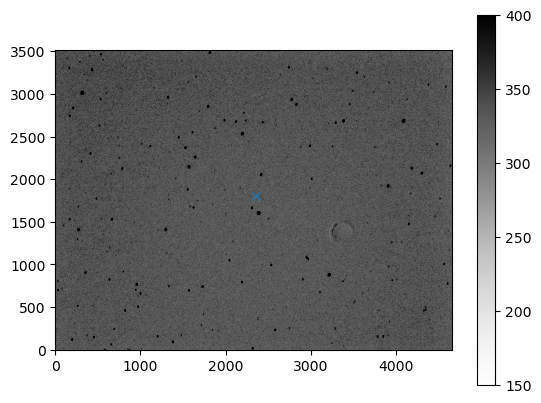

In [3]:
#read in raw image
raw_im = CCDData.read('./RZ Cep/All_RZ_Cep/2022_12_07/RZ_Cep/Lights/Luminance Reduced/star_Light_Luminance_5_secs_155_reduced.fits')

#plot the image, scaling it to see more of the stars
plt.imshow(raw_im.data, cmap='Greys', vmin=150, vmax=400)
plt.gca().invert_yaxis()
#plot an x to estimate star position
plt.plot(2350, 1800, marker='x')
plt.colorbar()
plt.show()

Text(0, 0.5, 'Recieved Counts (photons)')

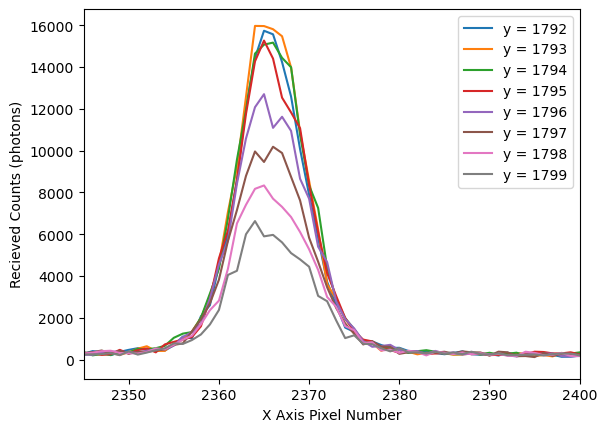

In [5]:
#plot a slice of the image at y = pix value
plt.plot(raw_im.data[1792], label='y = 1792')
plt.plot(raw_im.data[1793], label='y = 1793')
plt.plot(raw_im.data[1794], label='y = 1794')
plt.plot(raw_im.data[1795], label='y = 1795')
plt.plot(raw_im.data[1796], label='y = 1796')
plt.plot(raw_im.data[1797], label='y = 1797')
plt.plot(raw_im.data[1798], label='y = 1798')
plt.plot(raw_im.data[1799], label='y = 1799')
plt.legend()

y_peak = 1793
#peaks at y_pix = 1793 for 2022_12_07, so this is the approximate y location
#peaks at y_pix = 1756 for 2023_01_23, so this is the approximate y location

#find the rough location of the peak (range)
plt.xlim(2345, 2400)

plt.xlabel('X Axis Pixel Number')
plt.ylabel('Recieved Counts (photons)')

Text(0, 0.5, 'Recieved Counts (photons)')

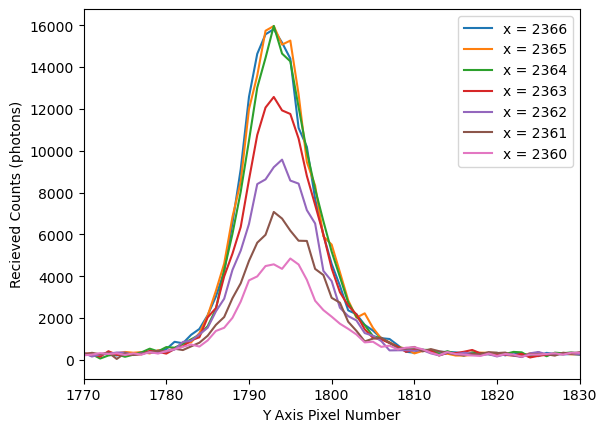

In [6]:
#plot a slice of the image across the x axis
plt.plot(raw_im.data[:, 2366], label='x = 2366')
plt.plot(raw_im.data[:, 2365], label='x = 2365')
plt.plot(raw_im.data[:, 2364], label='x = 2364')
plt.plot(raw_im.data[:, 2363], label='x = 2363')
plt.plot(raw_im.data[:, 2362], label='x = 2362')
plt.plot(raw_im.data[:, 2361], label='x = 2361')
plt.plot(raw_im.data[:, 2360], label='x = 2360')
plt.legend()

#if less iterations, initial guess was more accurate

x_peak = 2365
#peaks at x_pix = 2365 for 2022_12_07, so this is the approximate location
#peaks at x_pix = 2371 for 2023_01_23, so this is the approximate location

#find approximate peak location range
plt.xlim(1770, 1830)

plt.xlabel('Y Axis Pixel Number')
plt.ylabel('Recieved Counts (photons)')

In [8]:
#defined a fitter algorithm for fitting the Gaussian, in this case the Levenberg-Marquardt, which uses a least squares method
algorithm = modeling.fitting.LevMarLSQFitter()
#define Gaussian to fit, with test peak value, mean and standard deviation
#mean found from approx y location
model_y = modeling.models.Gaussian1D(16000, y_peak, 3)

#define the x range of the data (AKA the number of pixels in the y direction)
x_range_y = np.linspace(0, len(raw_im.data[:, x_peak]), len(raw_im.data[:, x_peak]))
#apply the algortihm to the model, which fits the model to the data
gaussian_fit_y = algorithm(model_y, x_range_y, raw_im.data[:, x_peak])

(1770.0, 1830.0)

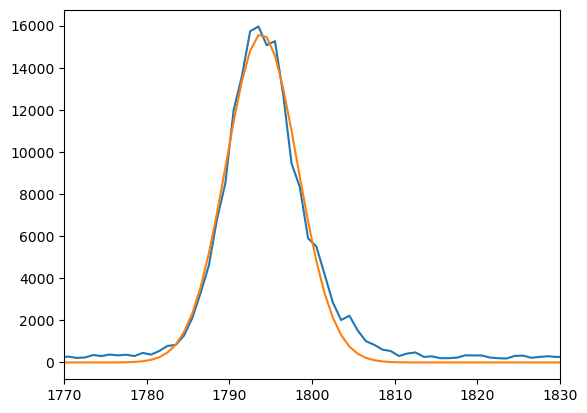

In [10]:
#plot original data and Gaussian curve to find new trial values
plt.plot(x_range_y, raw_im.data[:, x_peak])
plt.plot(x_range_y, gaussian_fit_y(x_range_y))
plt.xlim(1770, 1830)

calculate variance using imntegral of (data^2 x probability function of data) - mean^2

In [11]:
#find the half height of the gaussian
half_max_y = (np.max(raw_im.data[:, x_peak]) - np.min(raw_im.data[:, x_peak]))/2
print(half_max_y)

#find the closest data point and print its index (argmin returns the index)
closest_y = (np.abs(gaussian_fit_y(x_range_y)-half_max_y)).argmin()
print(closest_y)

#this is the full width half maximum of the star in y direction. 
FWHM_y = np.abs(closest_y - y_peak) * 2
print(FWHM_y)

7965.798899047637
1788
10


In [12]:
#define Gaussian to fit, with test peak value, mean and standard deviation
#mean found from approx y location
model_x = modeling.models.Gaussian1D(16000, x_peak, 3)

#define the x range of the data (AKA the number of pixels in the x direction)
x_range_x = np.linspace(0, len(raw_im.data[y_peak]), len(raw_im.data[y_peak]))
#apply the algortihm to the model, which fits the model to the data
gaussian_fit_x = algorithm(model_x, x_range_x, raw_im.data[y_peak])

(2345.0, 2400.0)

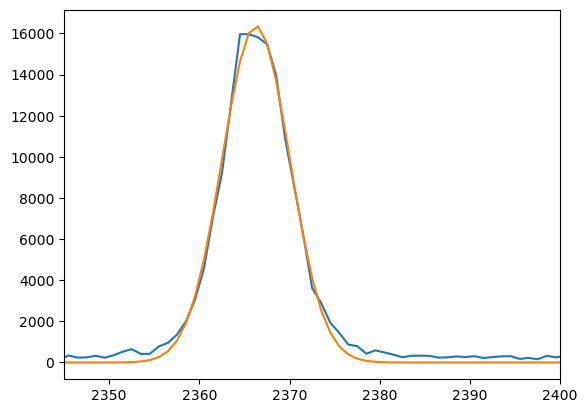

In [13]:
#plot original data and Gaussian curve to find new trial values
plt.plot(x_range_x, raw_im.data[y_peak])
plt.plot(x_range_x, gaussian_fit_x(x_range_x))
plt.xlim(2345, 2400)

In [14]:
#find the half height of the gaussian
half_max_x = (np.max(raw_im.data[y_peak]) - np.min(raw_im.data[y_peak]))/2
print(half_max_x)

#find the closest data point and print its index (argmin returns the index)
closest_x = (np.abs(gaussian_fit_x(x_range_x)-half_max_x)).argmin()
print(closest_x)

#this is the full width half maximum of the star in x direction. 
FWHM_x = np.abs(closest_x - x_peak) * 2
print(FWHM_x)
FWHM = (FWHM_x + FWHM_y)/2
print(FWHM)

7972.339947420372
2370
10
10.0


In [11]:
#find image stats
bkg_mean, bkg_median, bkg_std = sigma_clipped_stats(raw_im.data, sigma=4, stdfunc=mad_std)

#use DAOStarFinder algorithm to search for stars
daofind = DAOStarFinder(fwhm=FWHM, threshold=5.0 * bkg_std, brightest=5)
#subtract background median to reduce effect of background noise
stars = daofind(raw_im.data - bkg_median)
print(stars)

C:\ProgramData\Anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


 id     xcentroid      ...        flux               mag        
--- ------------------ ... ------------------ ------------------
  1 2371.9010354320517 ...  267.3678126521246 -6.067772807717299
  2 3205.6006688065177 ... 120.08161956752163 -5.198691341752559
  3 290.79960535166265 ... 115.75627855986987 -5.158861390584715
  4  4065.002066033998 ...  78.83882929289138 -4.741850416637358
  5  2143.338385216453 ...  70.16320547135709 -4.615273554897301


In [12]:
#plot how number of stars detected changes with threshold
'''
factor = 0.5
threshold_array = []
number_stars = []
while factor <= 20.0:
    threshold = factor * bkg_std
    daofind_ = DAOStarFinder(fwhm=FWHM, threshold=threshold)
    stars_ = daofind_(raw_im.data-bkg_std)
    threshold_array.append(factor)
    number_stars.append(len(stars_['xcentroid']))
    factor += 0.5
'''

"\nfactor = 0.5\nthreshold_array = []\nnumber_stars = []\nwhile factor <= 20.0:\n    threshold = factor * bkg_std\n    daofind_ = DAOStarFinder(fwhm=FWHM, threshold=threshold)\n    stars_ = daofind_(raw_im.data-bkg_std)\n    threshold_array.append(factor)\n    number_stars.append(len(stars_['xcentroid']))\n    factor += 0.5\n"

In [13]:
'''
plt.plot(threshold_array, number_stars, label='Test Data')
plt.plot([5]*20000, np.linspace(0, 21000, 20000), label='Chosen Threshold')
plt.xlabel('Threshold Value (Multiple of Background MAD)')
plt.ylabel('Number of Stars Detected')
plt.title('FWHM = 11 Pixels')
plt.legend()
plt.show()
'''

"\nplt.plot(threshold_array, number_stars, label='Test Data')\nplt.plot([5]*20000, np.linspace(0, 21000, 20000), label='Chosen Threshold')\nplt.xlabel('Threshold Value (Multiple of Background MAD)')\nplt.ylabel('Number of Stars Detected')\nplt.title('FWHM = 11 Pixels')\nplt.legend()\nplt.show()\n"

In [14]:
#plot how number of stars detected changes with full-width-half-maximum
'''
fw_hm = 0.5
fwhm_array = []
number_stars = []
while fw_hm <= 25.0:
    daofind_ = DAOStarFinder(fwhm=fw_hm, threshold=5 * bkg_std)
    stars_ = daofind_(raw_im.data-bkg_std)
    fwhm_array.append(fw_hm)
    number_stars.append(len(stars_['xcentroid']))
    fw_hm += 0.5
'''

"\nfw_hm = 0.5\nfwhm_array = []\nnumber_stars = []\nwhile fw_hm <= 25.0:\n    daofind_ = DAOStarFinder(fwhm=fw_hm, threshold=5 * bkg_std)\n    stars_ = daofind_(raw_im.data-bkg_std)\n    fwhm_array.append(fw_hm)\n    number_stars.append(len(stars_['xcentroid']))\n    fw_hm += 0.5\n"

In [15]:
'''
newstars = np.transpose((stars['xcentroid'], stars['ycentroid']))
apertures = CircularAperture(newstars, r=FWHM*2)
#use the apertures to find image specific fwhm
aperstats = ApertureStats(raw_im.data, apertures)
new_FWHM = aperstats.fwhm
FWHM = float((new_FWHM[0]) / (1 * u.pix))
print(FWHM)

plt.plot(fwhm_array, number_stars, label='Test FWHM')
plt.plot([FWHM]*627, np.linspace(150, 627, 627), label='Chosen FWHM from APStats')
plt.xlabel('Full-Width-Half-Maximum (Pixels)')
plt.ylabel('Number of Stars Detected')
plt.title('Threshold = 5 Background MADs')
plt.legend()
plt.show()
'''

"\nnewstars = np.transpose((stars['xcentroid'], stars['ycentroid']))\napertures = CircularAperture(newstars, r=FWHM*2)\n#use the apertures to find image specific fwhm\naperstats = ApertureStats(raw_im.data, apertures)\nnew_FWHM = aperstats.fwhm\nFWHM = float((new_FWHM[0]) / (1 * u.pix))\nprint(FWHM)\n\nplt.plot(fwhm_array, number_stars, label='Test FWHM')\nplt.plot([FWHM]*627, np.linspace(150, 627, 627), label='Chosen FWHM from APStats')\nplt.xlabel('Full-Width-Half-Maximum (Pixels)')\nplt.ylabel('Number of Stars Detected')\nplt.title('Threshold = 5 Background MADs')\nplt.legend()\nplt.show()\n"

In [16]:
#define new array of all star positions
newstars = np.transpose((stars['xcentroid'], stars['ycentroid']))
#define circular apertures for all star positions
apertures = CircularAperture(newstars, r=FWHM*2)
#perform apertury photometry on the apertures
#phot_table = aperture_photometry(raw_im.data, apertures)
#print(phot_table)
#define saturation level. factor is arbitrary and chosen by us, correcting for non linearity is beyond the scope of our projects
sat_level = np.power(2, 16) * 0.7
print(sat_level)
#set up aperture stats without background subtracted
ap_stats = ApertureStats(raw_im.data, apertures)
print(ap_stats.max)

#test if pixels are saturated
i = 0
while i < 5:
    if sat_level <= ap_stats.max[i]:
        print('star ', i, 'is saturated and cannot be used for photometry')
        i += 1
    else:
        i += 1      

45875.2
[38465.54692303 17010.05927588 17492.88561503 10388.67709019
  9816.52156893]


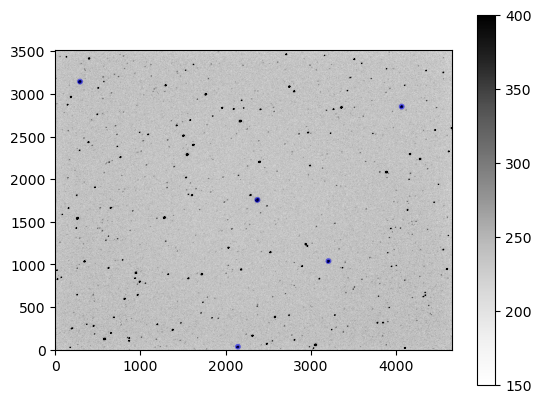

In [17]:
#plot the image, scaling it to see more of the stars
plt.imshow(raw_im.data, cmap='Greys', vmin=150, vmax=400)
plt.gca().invert_yaxis()
#plot apertures
apertures.plot(color='blue', lw=1.5, alpha=0.5)
plt.colorbar()
plt.show()

In [18]:
'''
r = 0.5
r_a = 0.5
r_in = 12*3
counts_recieved_ap = []
aperture_radius = []
counts_recieved_an = []
annulus_radius = []
bkg_for_aperture = []
corrected_counts = []
while r <= 150:
    apertures_ = CircularAperture(newstars, r=r)
    phot_table = aperture_photometry(raw_im.data-bkg_std, apertures_)
    counts_recieved_ap.append(np.array(phot_table['aperture_sum'])[0])
    aperture_radius.append(r)
    #print(r, np.array(phot_table['aperture_sum'])[0])

    annuli_ = CircularAnnulus(newstars, r_in=r_in, r_out=r_in+r_a)
    an_stats_ = ApertureStats(raw_im.data, annuli_)
    counts_recieved_an.append(an_stats_.median[0]*np.pi*(2*r_a*r_in+(r_a**2)))
    bkg_for_aperture.append(an_stats_.median[0]*np.pi*(r**2))
    annulus_radius.append(r_a + r_in)
    
    r_a += 0.5
    r += 0.5
'''

"\nr = 0.5\nr_a = 0.5\nr_in = 12*3\ncounts_recieved_ap = []\naperture_radius = []\ncounts_recieved_an = []\nannulus_radius = []\nbkg_for_aperture = []\ncorrected_counts = []\nwhile r <= 150:\n    apertures_ = CircularAperture(newstars, r=r)\n    phot_table = aperture_photometry(raw_im.data-bkg_std, apertures_)\n    counts_recieved_ap.append(np.array(phot_table['aperture_sum'])[0])\n    aperture_radius.append(r)\n    #print(r, np.array(phot_table['aperture_sum'])[0])\n\n    annuli_ = CircularAnnulus(newstars, r_in=r_in, r_out=r_in+r_a)\n    an_stats_ = ApertureStats(raw_im.data, annuli_)\n    counts_recieved_an.append(an_stats_.median[0]*np.pi*(2*r_a*r_in+(r_a**2)))\n    bkg_for_aperture.append(an_stats_.median[0]*np.pi*(r**2))\n    annulus_radius.append(r_a + r_in)\n    \n    r_a += 0.5\n    r += 0.5\n"

In [19]:
'''
#corrected_counts = counts_recieved_ap[:72] + [v1 - v2 for v1, v2 in zip(counts_recieved_ap[72:], counts_recieved_an[:-72])]
corrected_counts = counts_recieved_ap[:72] + [v1 - v2 for v1, v2 in zip(counts_recieved_ap[72:], bkg_for_aperture[:-72])]

plt.plot(aperture_radius, counts_recieved_ap, label='Test Aperture Size')
plt.plot(annulus_radius, counts_recieved_an, label='Test Annulus Size')
plt.plot(aperture_radius, corrected_counts, label='Corrected Aperture')
plt.plot([r_in]*100, np.linspace(0, 1.75e+7, 100), label='Aperture Radius Chosen')
plt.title('Counts Recieved for Varying Aperture and Annulus Size for RZ Cep')
plt.xlabel('Aperture Radius (Pixels)')
plt.ylabel('Counts Recieved (Counts)')
plt.xlim(0, 150)
plt.ylim(0, 1.75e7)
plt.legend()
plt.show()
'''

"\n#corrected_counts = counts_recieved_ap[:72] + [v1 - v2 for v1, v2 in zip(counts_recieved_ap[72:], counts_recieved_an[:-72])]\ncorrected_counts = counts_recieved_ap[:72] + [v1 - v2 for v1, v2 in zip(counts_recieved_ap[72:], bkg_for_aperture[:-72])]\n\nplt.plot(aperture_radius, counts_recieved_ap, label='Test Aperture Size')\nplt.plot(annulus_radius, counts_recieved_an, label='Test Annulus Size')\nplt.plot(aperture_radius, corrected_counts, label='Corrected Aperture')\nplt.plot([r_in]*100, np.linspace(0, 1.75e+7, 100), label='Aperture Radius Chosen')\nplt.title('Counts Recieved for Varying Aperture and Annulus Size for RZ Cep')\nplt.xlabel('Aperture Radius (Pixels)')\nplt.ylabel('Counts Recieved (Counts)')\nplt.xlim(0, 150)\nplt.ylim(0, 1.75e7)\nplt.legend()\nplt.show()\n"

In [20]:
#use the apertures to find new medians, means and standard deviations of the stars
aperstats = ApertureStats(raw_im.data, apertures)
new_FWHM = aperstats.fwhm

print(np.mean(new_FWHM), np.median(new_FWHM))
FWHM = float(np.median(new_FWHM) / (1 * u.pix))

15.491161149233884 pix 15.296539647756772 pix


In [21]:
#set up new star finder
daofind2 = DAOStarFinder(fwhm=FWHM, threshold=5*bkg_std, brightest=200)
stars2 = daofind2(raw_im.data - bkg_median)
#define new array of all star positions
newstars2 = np.transpose((stars2['xcentroid'], stars2['ycentroid']))
for col in stars2.colnames:
    stars2[col].info.format = '%.8g'  # for consistent table output
print(stars2)
#define radius of aperture
r = FWHM * 3.5
#define radius of annulus, so that it has the same area as the aperture
r_a = (np.sqrt(8)/2 - 1) * r
#define apertures and annuli
apertures2 = CircularAperture(newstars2, r=r)
annuli = CircularAnnulus(newstars2, r_in=r, r_out=r+r_a)
#run aperturestats on an to get measurements
ap_stats = ApertureStats(raw_im.data, apertures2)
an_stats = ApertureStats(raw_im.data, annuli)

 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag    
--- --------- --------- ---------- ... --- --------- --------- -----------
  1 2372.1448  1757.292 0.54028068 ...   0 36563.478 423.89033  -6.5681338
  2 290.55011 3145.3454 0.57106812 ...   0 16961.258 184.73422  -5.6663684
  3 3205.8657 1039.5551 0.62789512 ...   0 16774.062 182.52388  -5.6532992
  4 4065.0284 2852.2034 0.53635441 ...   0  10152.68 120.65564  -5.2038691
  5  2143.662 34.724591 0.53461413 ...   0 8684.6646 106.25606  -5.0658843
  6 1549.6648 2291.9202 0.49989961 ...   0 6792.4678 82.266843  -4.7880621
  7 3053.2323 59.325496 0.56714102 ...   0 6828.3797 80.836539  -4.7690193
  8 2171.7993  2685.017 0.53632459 ...   0 6744.8362 78.178729  -4.7327215
  9 3888.1324 2087.0046 0.61233192 ...   0  6999.878 77.837791  -4.7279763
 10 581.36024 127.96497 0.66518092 ...   0 7339.8639 77.629151  -4.7250621
...       ...       ...        ... ... ...       ...       ...         ...
190 3993.0693 1439.6643  

In [23]:
#calculate mean background for each annulus
bkg_mean = an_stats.median
#find total background in each aperture based upon area
total_bkg = np.pi * bkg_mean * r ** 2

#perform aperture photometry with new apertures
phot_table = aperture_photometry(raw_im.data, apertures2)
#find aperture sum total with background removed
phot_bkgsub = phot_table['aperture_sum'] - total_bkg
#add these to photometry table
phot_table['total_bkg'] = total_bkg
phot_table['aperture_sum_bkgsub'] = phot_bkgsub

counts = np.array(phot_table['aperture_sum'])
sky = an_stats.median * np.pi * (r_a **2)
corr_counts = counts - sky
exptime = raw_im.header['EXPTIME']
flux = corr_counts / 1.0
inst_mag = -2.5 * np.log10(flux)

for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)

print(np.sqrt(phot_table['aperture_sum_bkgsub'][0]))

 id  xcenter   ycenter  aperture_sum total_bkg aperture_sum_bkgsub
       pix       pix                                              
--- --------- --------- ------------ --------- -------------------
  1 2372.1448  1757.292    6682951.8 2119173.5           4563778.3
  2 290.55011 3145.3454    4363830.1 2134692.9           2229137.2
  3 3205.8657 1039.5551    3861361.3 2133727.1           1727634.2
  4 4065.0284 2852.2034    3387489.6 2145930.8           1241558.8
  5  2143.662 34.724591    2875572.6   2113639           761933.58
  6 1549.6648 2291.9202    3035132.8 2139361.6           895771.23
  7 3053.2323 59.325496    2918125.9 2154230.3           763895.69
  8 2171.7993  2685.017    2998105.4 2096724.5           901380.89
  9 3888.1324 2087.0046    2875934.8 2123465.1           752469.72
 10 581.36024 127.96497    2859434.7 2179878.4           679556.33
...       ...       ...          ...       ...                 ...
191  3295.992  267.1088    2192227.6 2166979.1            2524

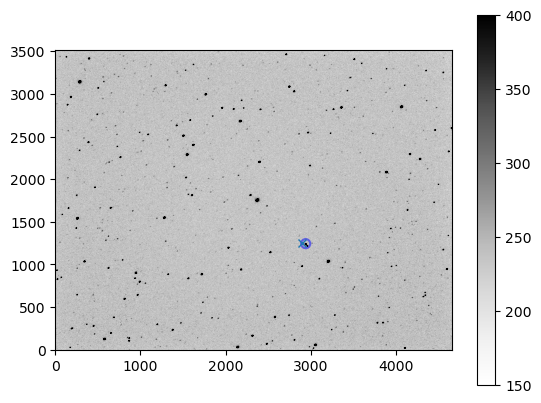

In [23]:
#plot the image, scaling it to see more of the stars
plt.imshow(raw_im.data, cmap='Greys', vmin=150, vmax=400)
plt.gca().invert_yaxis()
plt.plot(2900, 1250, marker='x')
#plot apertures
apertures2[35].plot(color='blue', lw=1.5, alpha=0.5)
plt.colorbar()
plt.show()

In [24]:
'''
r = 0.5
r_a = 0.5
r_in = 15*3
counts_recieved_ap = []
aperture_radius = []
counts_recieved_an = []
annulus_radius = []
bkg_for_aperture = []
corrected_counts = []
while r <= 150:
    apertures2_ = CircularAperture(newstars2, r=r)
    phot_table2 = aperture_photometry(raw_im.data-bkg_std, apertures2_)
    counts_recieved_ap.append(np.array(phot_table2['aperture_sum'])[35])
    aperture_radius.append(r)
    #print(r, np.array(phot_table['aperture_sum'])[0])

    annuli2_ = CircularAnnulus(newstars2, r_in=r_in, r_out=r_in+r_a)
    an_stats2_ = ApertureStats(raw_im.data, annuli2_)
    counts_recieved_an.append(an_stats2_.median[35]*np.pi*(2*r_a*r_in+(r_a**2)))
    bkg_for_aperture.append(an_stats2_.median[35]*np.pi*(r**2))
    annulus_radius.append(r_a + r_in)
    
    r_a += 0.5
    r += 0.5
'''

"\nr = 0.5\nr_a = 0.5\nr_in = 15*3\ncounts_recieved_ap = []\naperture_radius = []\ncounts_recieved_an = []\nannulus_radius = []\nbkg_for_aperture = []\ncorrected_counts = []\nwhile r <= 150:\n    apertures2_ = CircularAperture(newstars2, r=r)\n    phot_table2 = aperture_photometry(raw_im.data-bkg_std, apertures2_)\n    counts_recieved_ap.append(np.array(phot_table2['aperture_sum'])[35])\n    aperture_radius.append(r)\n    #print(r, np.array(phot_table['aperture_sum'])[0])\n\n    annuli2_ = CircularAnnulus(newstars2, r_in=r_in, r_out=r_in+r_a)\n    an_stats2_ = ApertureStats(raw_im.data, annuli2_)\n    counts_recieved_an.append(an_stats2_.median[35]*np.pi*(2*r_a*r_in+(r_a**2)))\n    bkg_for_aperture.append(an_stats2_.median[35]*np.pi*(r**2))\n    annulus_radius.append(r_a + r_in)\n    \n    r_a += 0.5\n    r += 0.5\n"

In [25]:
'''
#corrected_counts = counts_recieved_ap[:72] + [v1 - v2 for v1, v2 in zip(counts_recieved_ap[72:], counts_recieved_an[:-72])]
corrected_counts = counts_recieved_ap[:72] + [v1 - v2 for v1, v2 in zip(counts_recieved_ap[72:], bkg_for_aperture[:-72])]

plt.plot(aperture_radius, counts_recieved_ap, label='Test Aperture Size')
plt.plot(annulus_radius, counts_recieved_an, label='Test Annulus Size')
plt.plot(aperture_radius, corrected_counts, label='Corrected Aperture')
plt.plot([r_in]*100, np.linspace(0, 1.75e+7, 100), label='Aperture Radius Chosen')
plt.title('Counts Recieved for Varying Aperture and Annulus Size for RZ Cep')
plt.xlabel('Aperture Radius (Pixels)')
plt.ylabel('Counts Recieved (Counts)')
plt.xlim(0, 150)
plt.ylim(0, 1.75e7)
plt.legend()
plt.show()
'''

"\n#corrected_counts = counts_recieved_ap[:72] + [v1 - v2 for v1, v2 in zip(counts_recieved_ap[72:], counts_recieved_an[:-72])]\ncorrected_counts = counts_recieved_ap[:72] + [v1 - v2 for v1, v2 in zip(counts_recieved_ap[72:], bkg_for_aperture[:-72])]\n\nplt.plot(aperture_radius, counts_recieved_ap, label='Test Aperture Size')\nplt.plot(annulus_radius, counts_recieved_an, label='Test Annulus Size')\nplt.plot(aperture_radius, corrected_counts, label='Corrected Aperture')\nplt.plot([r_in]*100, np.linspace(0, 1.75e+7, 100), label='Aperture Radius Chosen')\nplt.title('Counts Recieved for Varying Aperture and Annulus Size for RZ Cep')\nplt.xlabel('Aperture Radius (Pixels)')\nplt.ylabel('Counts Recieved (Counts)')\nplt.xlim(0, 150)\nplt.ylim(0, 1.75e7)\nplt.legend()\nplt.show()\n"

In [26]:
#isolate all variables for the csv files
#read in file header
#header = CCDData.read(raw_path / file_name, unit='adu').header
header = raw_im.header
date_time = header['DATE-OBS']

x_center = np.transpose(stars2['xcentroid'])
y_center = np.transpose(stars2['ycentroid'])
annulus_bkg = phot_table['total_bkg']
aperture_sum = phot_table['aperture_sum_bkgsub']
FWHM_arr = np.full(200, FWHM)
date_arr = [date_time] * 200
dao_flux = np.transpose(stars2['flux'])
dao_mag = np.transpose(stars2['mag'])
dao_peak = np.transpose(stars2['peak'])

In [27]:
df1 = pd.DataFrame(data=(x_center, y_center, annulus_bkg, aperture_sum, date_arr, FWHM_arr, dao_flux, dao_mag, dao_peak))
df1 = df1.T
df1.columns = ['x_center', 'y_center', 'annulus_bkg', 'aperture_sum', 'date_time', 'FWHM', 'dao_flux', 'dao_mag', 'dao_peak']
df1

,x_center,y_center,annulus_bkg,aperture_sum,date_time,FWHM,dao_flux,dao_mag,dao_peak
0,2372.144777,1757.292027,2119173.492298,4563778.270634,2023-01-23T20:55:06.901,15.29654,423.89033,-6.568134,36563.478053
1,290.550114,3145.34544,2134692.945054,2229137.2038,2023-01-23T20:55:06.901,15.29654,184.734224,-5.666368,16961.257785
2,3205.86573,1039.555063,2133727.105048,1727634.170479,2023-01-23T20:55:06.901,15.29654,182.523882,-5.653299,16774.061727
3,4065.028417,2852.203407,2145930.833397,1241558.795022,2023-01-23T20:55:06.901,15.29654,120.65564,-5.203869,10152.679541
4,2143.662037,34.724591,2113639.01144,761933.577543,2023-01-23T20:55:06.901,15.29654,106.256064,-5.065884,8684.6646
...,...,...,...,...,...,...,...,...,...
195,3648.807036,1655.017819,2092453.71575,62333.443836,2023-01-23T20:55:06.901,15.29654,2.25783,-0.884228,136.591521
196,3884.802341,60.740945,2147082.025398,46328.953675,2023-01-23T20:55:06.901,15.29654,2.254928,-0.882832,241.629833
197,4189.897685,1357.394112,2145770.330082,37704.523937,2023-01-23T20:55:06.901,15.29654,2.24224,-0.876705,189.355132
198,3331.376645,1185.556745,2132481.523818,26807.50492,2023-01-23T20:55:06.901,15.29654,2.229107,-0.870327,133.941889


In [28]:
#find star positions and other stats for all images

#define path for csv files to be written to
file_path = Path(f'./RZ Cep/2023_1_23/Photometry Practise/CSV Star Locations M')
#set the path to the current file we are looking at
current_raw_path = './RZ Cep/2023_1_23/Photometry Practise/'
#create a list of files in the directory (file) indicated by the path, just in case some sub folders exist or files that are
#not of the FITS type.
file_list = [f for f in os.listdir(current_raw_path) if f.endswith(".fits")]
#convert the path from a string into a Path object that can be put into functions
raw_path = Path(current_raw_path)
#read in the images
raw_ims = ccdp.ImageFileCollection(raw_path, filenames=file_list)
#for tracking how many files operations have been completed on
i = 0

for light, file_name in raw_ims.ccds(imagetyp='Light Frame', ccd_kwargs={'unit':'adu'}, return_fname=True):
    '''setup'''
    #read in header to find the date and time the image was taken
    date_time = CCDData.read(raw_path / file_name).header['DATE-OBS']
    exptime = CCDData.read(raw_path / file_name).header['EXPTIME']
    #assume a starting fwhm similar to that of the original image
    FWHM = 11.0
    #ensure we are working with only the image data
    light = light.data
    #find image stats of target image
    bkg_mean, bkg_median, bkg_std = sigma_clipped_stats(light, sigma=4, stdfunc=mad_std)
    #rename the files
    file_name = file_name.replace('.fits', '_stars')
    print('setup done')

    '''search for stars in the image'''
    #use DAOStarFinder algorithm to search for stars
    daofind = DAOStarFinder(fwhm=FWHM, threshold=5.0 * bkg_std, brightest=5)
    #subtract background median to reduce effect of background noise
    stars = daofind(light - bkg_median)
    
    del(daofind) #mem saving
    print('initial star search done')
    
    '''find an updated full-width-half-maximum'''
    #define new array of all star positions
    newstars = np.transpose((stars['xcentroid'], stars['ycentroid']))
    #define circular apertures for all star positions
    apertures = CircularAperture(newstars, r=FWHM*2)
    #use the apertures to find image specific fwhm
    aperstats = ApertureStats(light, apertures)
    new_FWHM = aperstats.fwhm
    #aperstats outputs as a Quantity datatype, convert back to a number
    FWHM = float(np.median(new_FWHM) / (1 * u.pix))
    print('updated full-width-half-maximum')
    
    '''find stars again using new full-width-half-maximum'''
    #set up new star finder
    daofind2 = DAOStarFinder(fwhm=FWHM*2, threshold=5*bkg_std, brightest=200)
    #subtract background median to reduce noise again
    stars2 = daofind2(light - bkg_median)
    print(len(stars2))
    #define new array of all star positions
    newstars2 = np.transpose((stars2['xcentroid'], stars2['ycentroid']))
    print('secondary search done')

    '''set up new apertures and annuli for aperture photometry'''
    #define radius of aperture
    r = FWHM * 3
    #define radius of annulus, so that it has the same area as the aperture
    r_a = (np.sqrt(8)/2 - 1) * r
    #define apertures and annuli
    apertures2 = CircularAperture(newstars2, r=r)
    annuli = CircularAnnulus(newstars2, r_in=r, r_out=r+r_a)
    print('apertures and annuli defined')
    
    '''test for saturation'''
    #define saturation level. factor is arbitrary and chosen by us, correcting for non linearity is 
    #beyond the scope of our projects
    sat_level = np.power(2, 16) * 0.7
    #set up aperture stats without background subtracted
    ap_stats = ApertureStats(light, apertures2)

    #test if pixels are saturated
    j = 0
    saturated = []
    while j < 200:
        if sat_level <= ap_stats.max[j]:
            print('star ', j, 'is saturated and cannot be used for photometry')
            saturated.append(True)
            j += 1
        else:
            saturated.append(False)
            j += 1 
    print('tested for saturation')

    '''isolate useful image properties and perform aperture photometry for the rest'''
    #run aperturestats on annuli
    an_stats = ApertureStats(light, annuli)
    #perform aperture photometry with new apertures
    phot_table = aperture_photometry(light, apertures2)
    #extract recorded counts for the star
    counts = np.array(phot_table['aperture_sum'])
    #extract sky value of the annunli using their median and multiplying it by the total area of the aperture
    #more accurate background that is star specfic
    sky = an_stats.median * np.pi * (r ** 2)
    #correct the aperture photometry for the sky value, counts are now purely from star
    corr_counts = counts - sky
    #calculate flux using exposure time
    flux = corr_counts / 1.0
    #calculate instrumental magnitude from flux
    inst_mag = -2.5 * np.log10(flux)
    print('aperture photometry completed')
   
    '''write to a dataframe'''
    #set up dataframe of 200 star positions and flux read from aperture photometry
    x_center = np.transpose(stars2['xcentroid'])
    y_center = np.transpose(stars2['ycentroid'])
    annulus_bkg = sky
    counts_raw = counts
    FWHM_arr = np.full(200, FWHM)
    date_arr = [date_time] * 200
    exp_time = [exptime] * 200
    sky_corr_counts = corr_counts
    flux_calc = flux
    mag_calc = inst_mag
    print('dataframe info isolated')
   
    '''write to a csv file'''
    df = pd.DataFrame(data=(x_center, y_center, annulus_bkg, counts_raw, sky_corr_counts, 
                            flux_calc, mag_calc, saturated, FWHM_arr, date_arr, exp_time))
    df = df.T
    df.columns = ['x_center', 'y_center', 'annulus_bkg', 'counts', 'sky_corrected_counts', 
                  'flux', 'instrumental_mag', 'saturated?', 'FWHM', 'date_time', 'exp_time']
    #write csv file contating positions and fluxes for that image
    df.to_csv(file_path / f'{file_name}.csv')
    print('dataframe created')
    #track how many files have been through the loop
    i += 1
    print('csv file written, ', i, 'files completed')

print('all done!!!')

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


KeyboardInterrupt: 

# Solve for star positions #

In [ ]:
from astroquery.simbad import Simbad

#get all info Simbad has on our main star
#set up Simbad search
customSimbad = Simbad()
#add fields to output
customSimbad.add_votable_fields('otype','flux(U)','flux(B)','flux(V)','flux(R)','flux(I)','flux(G)','flux(J)','flux(H)',
                                'flux(K)','flux(u)','flux(g)','flux(r)','flux(i)','flux(z)','ra(deg)','dec(deg)','ids')

#search for object and its properties, saving to a dataframe
RZ_Cep = customSimbad.query_object('RZ Cep')
df_RZ_Cep = RZ_Cep.to_pandas()

#find star position
RZ_Cep_ra = df_RZ_Cep['RA_deg'][0]
RZ_Cep_dec = df_RZ_Cep['DEC_deg'][0]
print(RZ_Cep_ra, RZ_Cep_dec)

In [ ]:
from astroquery.astrometry_net import AstrometryNet
from astropy.wcs import WCS

file_path = Path('./RZ Cep/2023_1_23/Photometry Practise/CSV Star Locations M')
df1 = pd.read_csv(file_path / 'star_Light_Luminance_10_secs_001_reduced_stars.csv', delimiter=',')
raw_im = CCDData.read('./RZ Cep/2023_1_23/Photometry Practise/star_Light_Luminance_10_secs_001_reduced.fits')

#set up Astrometry.net solver, which compares image to the sky to find exact sky position
ast = AstrometryNet()
ast.api_key = 'uktlwsvagbqfbbwl'

#define image size
image_width = len(raw_im.data[1756])
image_height = len(raw_im.data[:, 2371])
print(image_width, image_height)

#extract important information 
wcs_header = ast.solve_from_source_list(df1['x_center'], df1['y_center'], #input star positions to be compared
                                        image_width, image_height, #image size for matching to the sky
                                        solve_timeout=120, #max time for the solving to be done in
                                        #scale_type='ul',
                                        scale_est = raw_im.header['SCALE'], #check header to see if scaling is required
                                        scale_err = 5, #estimate scale error
                                        #scale_lower = raw_im.header['SCALE'] * 0.9,
                                        #scale_upper = raw_im.header['SCALE'] * 1.1,
                                        scale_units = 'arcsecperpix', #units of scaling
                                        crpix_center=True, #force reference point to be centre of image
                                        center_ra = RZ_Cep_ra, #set image centre as star centre
                                        center_dec = RZ_Cep_dec, 
                                        radius = (raw_im.header['SCALE'] * image_width)/3600 #uncertain
                                       )

In [ ]:
#convert extracted information into a worl coordinate system for the image, which is added to the image header
w = WCS(wcs_header)
print(w)
#w['CRPIX'] = [df1['x_center'], df1['y_center']]
raw_im.header.update(w.to_header(), 'relax')

In [ ]:
raw_im.header['CRPIX1'] = df1['x_center'][0]
raw_im.header['CRPIX2'] = df1['y_center'][0]
raw_im.header

In [ ]:

#plot the image, scaling it to see more of the stars
plt.imshow(raw_im.data, cmap='Greys', vmin=150, vmax=400)
plt.gca().invert_yaxis()
#plot where solve_from_image_centre identified the reference point to be
#plt.plot(1900.69544356, 1951.98985245, marker='x')
#plt.plot(1790.61798821, 1817.22904639, marker='x')
plt.plot(raw_im.header['CRPIX1'], raw_im.header['CRPIX2'], marker='x')
plt.colorbar()
plt.show()


In [ ]:

from astropy import coordinates
import astropy.units as u

#convert pixel values to ra and dec
sky_all = w.pixel_to_world(df1['x_center'], df1['y_center'])
#append to original dataframe containing pixel position values
df1['ra_from_astrometry_deg'] = sky_all.ra.degree
df1['dec_from_astrometry_deg'] = sky_all.dec.degree

#save all stars, their names, ra and dec, Simbad properties within a vcertain radius of the centre to a dataframe
c = coordinates.SkyCoord(sky_all)
r = 1 * u.arcminute
result_table = customSimbad.query_region(c, radius=r)
df_results = result_table.to_pandas()


In [ ]:
df_results

In [ ]:
df1['star_id'] = df_results['MAIN_ID']
df1

In [ ]:
df1.to_csv(file_path / 'star_Light_Luminance_10_secs_001_reduced_stars.csv')

# Align Individual Images #

In [ ]:
#target_df = pd.read_csv('StarPositions.csv', index_col=0)
#target = pd.concat([target_df['xpos'], target_df['ypos']], axis=1)
#target